# **Toxic Comments Classification**

## Part 1 - Descriptive Analysis and Topic Modelling

## Introduction
You have a friend who works for Alphabet. He's helping work on tools to help improve online conversation. One area of focus is the study of negative online behaviours such as comments that are rude, disrespectful or otherwise likely to make others leave the conversation. He wants your help to compare toxic and non-toxic comments, and build a model to separate out the two and hopefully help online discussion to become more productive and respectful.

Note: the context for this analysis is the [Kaggle Toxic Comment Classification Challenge](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview)

He has provided you with a large number of Wikipedia comments labelled by human raters for toxic behaviour. The types of toxicity are:
- toxic
- severe toxic
- obscene
- threat
- insult
- identity hate

**Data dictionary**

|    | Variable      | Description                       |
|---:|:--------------|:----------------------------------|
|  0 | id            | comment unique identifier         |
|  1 | comment_text  | comment                           |
|  2 | toxic         | comment labelled as toxic         |
|  3 | severe toxic  | comment labelled as very toxic    |
|  4 | obscene       | comment labelled as obscene       |
|  5 | threat        | comment labelle as a threat       |
|  6 | insult        | comment labelled as an insult     |
|  7 | identity hate | comment labelled as identity hate |

In [11]:
# general data wrangling etc
import missingno as msno
import numpy as np
import pandas as pd
# import pickle
# from pprint import pprint
import time

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

# general text pre & postprocessing
import nltk
from nltk.tokenize import RegexpTokenizer
import re

# feature engineering
from textblob import TextBlob # sentiment

# topic modelling
import gensim # topic modelling
from gensim import models as gensim_models
import pyLDAvis
import pyLDAvis.gensim as gensimvis

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


True

In [80]:
# load the data
train = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

test_labels = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')
test_labels.drop('id', inplace=True, axis=1)

test = pd.concat([test, test_labels], axis=1)
# remove any unlabelled data
test = test.loc[test.toxic != -1, ]

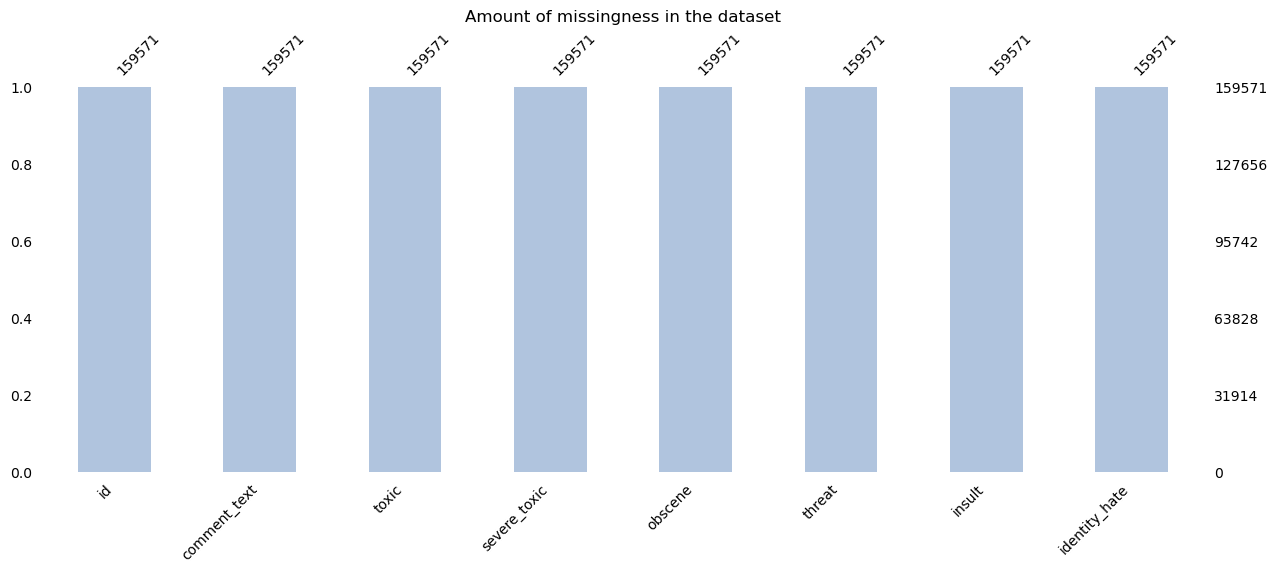

In [81]:
# assess missingness
fig, ax = plt.subplots(figsize=(15, 5))
msno.bar(train, fontsize=10, color='lightsteelblue', ax=ax)
ax.set_title("Amount of missingness in the dataset");

In [82]:
# convert to a binary classification problem
for df in [train, test]:
    int_cols = df.columns[2:]
    df['toxic_sum'] = df[int_cols].sum(axis=1)
    df['is_toxic'] = df.apply(lambda x: 1 if x['toxic_sum'] > 0 else 0, axis=1)

    df.drop('toxic_sum', axis=1, inplace=True)

# view a random sample of the training data
continue_loop = False
max_iter = 100
num_iter = 0

while not continue_loop and num_iter < max_iter:
    sample = train.sample(5)
    
    if 1 in sample['is_toxic'].values:
        continue_loop = True
    else:
        num_iter += 1
sample

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic
126897,a699a6b8ecb23d7b,Alphonse \n\nI just watched an awesome video o...,0,0,0,0,0,0,0
145184,18790a068bdd1848,"The 1993 World Series, Mitch the Wild Thing Wi...",0,0,0,0,0,0,0
99132,12518ca2f3a59624,"Well, we have a problem here, and nobody is do...",0,0,0,0,0,0,0
115352,68d9ba496a4276f5,"""\nWell, according to Kingofaces43 we must tre...",0,0,0,0,0,0,0
95742,0005be6eea9c30e8,Jeffrey O. Gustafson|Jeffrey O. Gustafson]] - ...,0,0,0,0,0,0,0


## **1. What is the most frequent category of hate speech?**

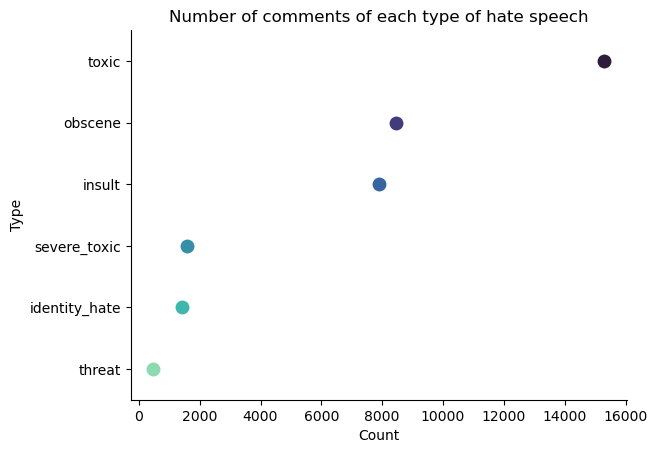

In [114]:
train_long = train.melt(id_vars=['id', 'comment_text'], var_name='toxicity_type')
plot_data = train_long.groupby('toxicity_type').sum().reset_index().sort_values(by='value', ascending=False)
plot_data = plot_data.loc[plot_data.toxicity_type != "is_toxic", ]

sns.stripplot(x="value", y="toxicity_type", data=plot_data, hue="toxicity_type", palette="mako", size=10, legend=False)
plt.xlabel("Count")
plt.ylabel("Type")
plt.title("Number of comments of each type of hate speech")
sns.despine()

## **2. What are the most common words used in each category?**

In [115]:
# preprocess the text data
def preprocess_text(text, remove_num=False, remove_sw=False, sw_lst=None, lemm=True, stem=False,
                    remove_single=True):
#     # convert to lowercase and strip out additional white space, then remove special characters
#     text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    # remove numbers
    if remove_num:
        text = re.sub(r'[\s\d+\s]', ' ', text)
        
#     # tokenise
#     text_lst = text.split()
   
    # convert strings to lowercase
    text = str(text).lower()
    
    # tokenise the strings
    tokeniser = RegexpTokenizer(r'\w+')
    tokenised_text = tokeniser.tokenize(text)
    
    # # remove numbers (but not words that contain numbers)
    # if remove_num:
    #     tokenised_text = [token for token in tokenised_text if not token.isnumeric()]
    
    # remove stopwords
    if remove_sw:
        tokenised_text = [token for token in tokenised_text if token not in sw_lst]
        
    # lemmatise (convert the word into root word)
    if lemm:
        lemmatiser = nltk.stem.wordnet.WordNetLemmatizer()
        tokenised_text = [lemmatiser.lemmatize(token) for token in tokenised_text]

    # stem (remove -ing, -ly, ...)
    if stem:
        stemmer = nltk.stem.porter.PorterStemmer()
        tokenised_text = [stemmer.stem(token) for token in tokenised_text]    

    # remove single-letter words
    if remove_single:
        tokenised_text = [token for token in tokenised_text if len(token) > 1]
    
    # join back together
    text = " ".join(tokenised_text)
    
    return text

# use the nltk stopwords list
stopword_lst = nltk.corpus.stopwords.words("english")
# apply the preprocessing to the comment_text
start_time = time.time()

train['processed_comment_text'] = train['comment_text'].apply(lambda x: preprocess_text(
    x, remove_sw=True, sw_lst=stopword_lst, remove_single=True, stem=False, lemm=True))

end_time = time.time()
print('Elapsed time: {:.2f} minutes'.format((end_time-start_time)/60))

Elapsed time: 0.96 minutes


Text(0.5, 1.0, 'Common words used in very toxic comments')

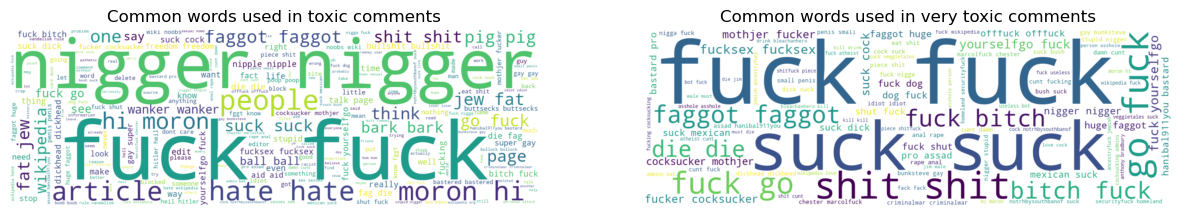

In [116]:
# identify the most common words used in toxic comments
fig, ax = plt.subplots(1,2, figsize=(15,5), facecolor=None)

wc = wordcloud.WordCloud(width=1500, height=500, background_color="white", min_font_size=10, include_numbers=True,
                         max_words=1000)
wc_data = train.loc[train.toxic == 1,]
wc.generate((" ".join(wc_data.processed_comment_text)))
ax[0].axis("off")
ax[0].imshow(wc, interpolation="bilinear")
ax[0].set_title("Common words used in toxic comments")

wc_data = train.loc[train.severe_toxic == 1,]
wc.generate((" ".join(wc_data.processed_comment_text)))
ax[1].axis("off")
ax[1].imshow(wc, interpolation="bilinear")
ax[1].set_title("Common words used in very toxic comments");

Elapsed time: 0.16 minutes


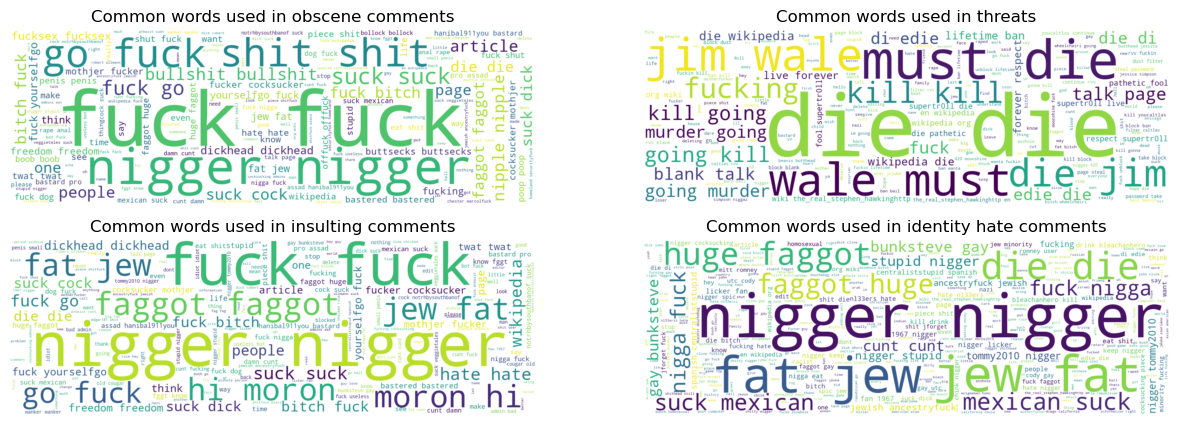

In [117]:
# what about obsene, threats, insults and identity hate?
fig, ax = plt.subplots(2,2, figsize=(15,5), facecolor=None)

start_time = time.time()
wc = wordcloud.WordCloud(width=1500, height=500, background_color="white", min_font_size=10, include_numbers=True,
                         max_words=1000)
wc_data = train.loc[train.obscene == 1,]
wc.generate((" ".join(wc_data.processed_comment_text)))
ax[0,0].axis("off")
ax[0,0].imshow(wc, interpolation="bilinear")
ax[0,0].set_title("Common words used in obscene comments")

wc_data = train.loc[train.threat == 1,]
wc.generate((" ".join(wc_data.processed_comment_text)))
ax[0,1].axis("off")
ax[0,1].imshow(wc, interpolation="bilinear")
ax[0,1].set_title("Common words used in threats")

wc_data = train.loc[train.insult == 1,]
wc.generate((" ".join(wc_data.processed_comment_text)))
ax[1,0].axis("off")
ax[1,0].imshow(wc, interpolation="bilinear")
ax[1,0].set_title("Common words used in insulting comments")

wc_data = train.loc[train.identity_hate == 1,]
wc.generate((" ".join(wc_data.processed_comment_text)))
ax[1,1].axis("off")
ax[1,1].imshow(wc, interpolation="bilinear")
ax[1,1].set_title("Common words used in identity hate comments");

end_time = time.time()
print('Elapsed time: {:.2f} minutes'.format((end_time-start_time)/60))

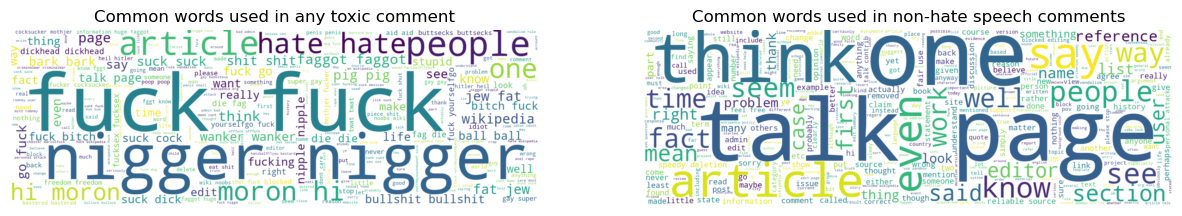

In [118]:
# what about any type of toxic vs non-toxic?
fig, ax = plt.subplots(1,2, figsize=(15,5), facecolor=None)

wc = wordcloud.WordCloud(width=1500, height=500, background_color="white", min_font_size=10, include_numbers=True,
                         max_words=1000)
wc_data = train.loc[train.is_toxic == 1,]
wc.generate((" ".join(wc_data.processed_comment_text)))
ax[0].axis("off")
ax[0].imshow(wc, interpolation="bilinear")
ax[0].set_title("Common words used in any toxic comment")

wc_data = train.loc[train.is_toxic == 0,]
wc.generate((" ".join(wc_data.processed_comment_text)))
ax[1].axis("off")
ax[1].imshow(wc, interpolation="bilinear")
ax[1].set_title("Common words used in non-hate speech comments");

## **3. What is the overall sentiment of the comments?**

In [130]:
start_time = time.time()

train["sentiment"] = train.loc[train['comment_text'].notna(), 'comment_text'].apply(
    lambda x: TextBlob(x).sentiment.polarity)

end_time = time.time()
print('Elapsed time: {:.2f} minutes'.format((end_time-start_time)/60))

summary_stats = train[['sentiment']].describe()
summary_stats.rename(columns={'sentiment':'overall'}, inplace=True)

data_cols = train.columns[2:9].tolist()
# compute the opposite to 'is_toxic'
train['non_toxic'] = 1 - train[data_cols[-1]]
data_cols = data_cols + ['non_toxic']

for col in data_cols:
    summary_stats[col] = train.loc[train[col] == 1, ['sentiment']].describe()
summary_stats

Elapsed time: 1.74 minutes


,overall,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic,non_toxic
count,159571.000000,15294.000000,1595.000000,8449.000000,478.000000,7877.000000,1405.000000,16225.000000,143346.000000
mean,0.073185,-0.116569,-0.253093,-0.156624,-0.153801,-0.170417,-0.093505,-0.110472,0.093973
std,0.239458,0.322102,0.302461,0.310961,0.320534,0.324004,0.323704,0.319139,0.219210
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,-0.300000,-0.433333,-0.387500,-0.377679,-0.400000,-0.276364,-0.300000,0.000000
50%,0.030000,-0.035105,-0.266667,-0.100000,-0.091401,-0.116721,-0.041667,-0.027567,0.050000
75%,0.192857,0.020337,0.000000,0.000000,0.000000,0.000000,0.048655,0.030295,0.200000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


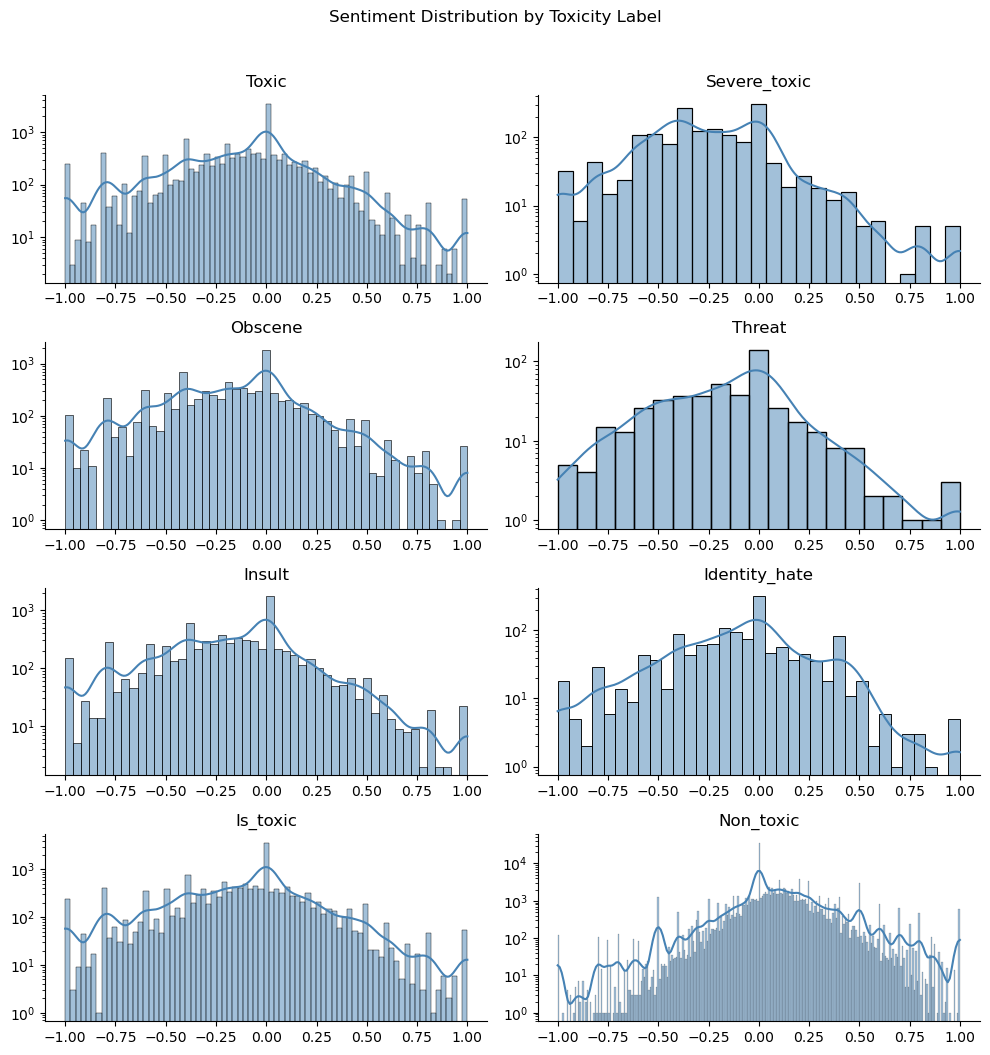

In [132]:
fig, axs = plt.subplots(4, 2, figsize=(10,10), sharey=False)
axs = axs.flatten()

for i, col in enumerate(data_cols):
    plot_data = train.loc[train[col] == 1, ['sentiment']].dropna()
    sns.histplot(data=plot_data, x='sentiment', kde=True, ax=axs[i], color='steelblue')
    axs[i].set_title(col.capitalize())
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    axs[i].set_yscale('log')

fig.tight_layout()
sns.despine()

plt.suptitle('Sentiment Distribution by Toxicity Label', y=1.05);

# drop the non_toxic column we created
train.drop('non_toxic', inplace=True, axis=1)

## **4. Are there any themes in the toxic comments, other than those indicated by the word clouds?**

In [134]:
def generate_model_input(processed_text):
    corpus = processed_text
    tokenised_corpus = [string.split() for string in corpus]

    bigram = gensim_models.Phrases(tokenised_corpus, min_count=20)
    for idx in range(len(tokenised_corpus)):
        for token in bigram[tokenised_corpus[idx]]:
            if '_' in token:
                tokenised_corpus[idx].append(token)
    
    # # pre-process the texts/corpus into lists of bigrams
    # ngram_length = 2
    # new_tokenised_corpus = []
    # for doc in tokenised_corpus:
    #     ngrams_lst = [" ".join(doc[i:i + ngram_length]) for i in range(0, len(doc), ngram_length)]
    #     new_tokenised_corpus.append(ngrams_lst)

    # create a dictionary representation of the articles
    dictionary = gensim.corpora.Dictionary(tokenised_corpus)

    # transform the articles into a vectorised form i.e. compute the frequency of each term
    # BoW representation of the articles
    bow_corpus = [dictionary.doc2bow(doc) for doc in tokenised_corpus]

    # make an index to word dictionary
    temp = dictionary[0]
    id2word = dictionary.id2token
    
    return bow_corpus, dictionary, id2word, tokenised_corpus

def generate_topics(bow_corpus, id2word, num_topics):
    # note that it doesn't actually matter whether id2word is dictionary.id2token or dictionary
    
    # set training parameters
    num_topics = num_topics
    eval_every = None # high computational cost if want to evaluate model perplexity

    lda_model = gensim_models.ldamodel.LdaModel(corpus=bow_corpus,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                update_every=1,
                                                chunksize=100,
                                                passes=20,
                                                iterations=400,
                                                alpha='auto',
                                                eta='auto',
                                                eval_every=eval_every,
                                                per_word_topics=True)
    
    # get the output
    dict_lsts = []
    for i in range(0, num_topics):
        tuples_lst = lda_model.get_topic_terms(i)
        for tuple in tuples_lst:
            dict_lsts.append({"topic": i,
                              "id": tuple[0],
                              "ngram": id2word[tuple[0]],
                              "weight": tuple[1]})
    topics_df = pd.DataFrame(dict_lsts, columns=['topic', 'id', 'ngram', 'weight'])

    return topics_df, lda_model, num_topics

processed_text = train.loc[train.is_toxic == 1, 'processed_comment_text']
# generate the model input
bow_corpus, dictionary, id2word, tokenised_corpus = generate_model_input(processed_text)

In [135]:
# train the model and analyse topic coherence
start_time = time.time()

coherence_lst = []
for i in range(2, 21, 2):
    print('Generating a LDA model with', i, 'topics...')
    # recall '_' means we don't care about that function output
    _, lda_model, _ = generate_topics(bow_corpus, id2word, num_topics=i)
    print('Generating coherence scores...')
    top_topics = lda_model.top_topics(corpus=bow_corpus, topn=20, coherence='u_mass')
#     top_topics = lda_model.top_topics(corpus=bow_corpus, texts=tokenised_corpus,
#                                       dictionary=dictionary, coherence='c_v', topn=20)
    avg_coherence = sum([t[1] for t in top_topics]) / i
    print('Avg coherence is', round(avg_coherence, 4))
    coherence_lst.append((i, avg_coherence))
print("Finished")

end_time = time.time()
print('Elapsed time: {:.2f} minutes'.format((end_time-start_time)/60))

Generating a LDA model with 2 topics...
Generating coherence scores...
Avg coherence is -10.6967
Generating a LDA model with 4 topics...
Generating coherence scores...
Avg coherence is -10.7732
Generating a LDA model with 6 topics...
Generating coherence scores...
Avg coherence is -8.2424
Generating a LDA model with 8 topics...
Generating coherence scores...
Avg coherence is -8.0149
Generating a LDA model with 10 topics...
Generating coherence scores...
Avg coherence is -7.6894
Generating a LDA model with 12 topics...
Generating coherence scores...
Avg coherence is -8.6744
Generating a LDA model with 14 topics...
Generating coherence scores...
Avg coherence is -7.1769
Generating a LDA model with 16 topics...
Generating coherence scores...
Avg coherence is -8.2527
Generating a LDA model with 18 topics...
Generating coherence scores...
Avg coherence is -7.4968
Generating a LDA model with 20 topics...
Generating coherence scores...
Avg coherence is -7.2587
Finished
Elapsed time: 44.50 min

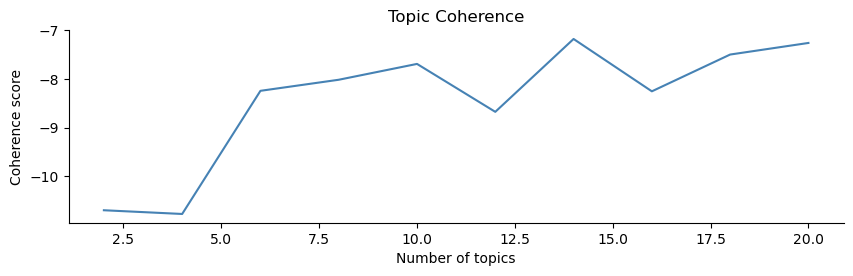

In [136]:
coherence_df = pd.DataFrame(coherence_lst, columns=["topics", "coherence"])

fig, ax = plt.subplots(figsize=(10, 2.5))
sns.lineplot(coherence_df, x="topics", y="coherence", color='steelblue')
ax.set_title("Topic Coherence")
ax.set_xlabel("Number of topics")
ax.set_ylabel("Coherence score")
sns.despine();

In [141]:
# locate the highest coherence score
idx = np.argmax(coherence_df['coherence'])
best_num = coherence_df.iloc[idx]['topics'].astype(int)
num_topics = 10

# re-train the model
start_time = time.time()

bow_corpus, dictionary, id2word, tokenised_corpus = generate_model_input(processed_text)
topics_df, lda_model, num_topics = generate_topics(bow_corpus, id2word, num_topics=num_topics)

end_time = time.time()
print('Elapsed time: {:.2f} minutes'.format((end_time-start_time)/60))

# compute how many tokens are documents were being trained on
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(bow_corpus))
print('Number of topics: %d' % num_topics)

Elapsed time: 4.31 minutes
Number of unique tokens: 32906
Number of documents: 16225
Number of topics: 10


In [142]:
pyLDAvis.enable_notebook()
comments_data = gensimvis.prepare(topic_model=lda_model, dictionary=dictionary, corpus=bow_corpus, mds='mmds')
comments_data

# mmds = Metric Multidimensional Scaling
# pcoa = Principal Coordinate Analysis
# tsne = t-distributed Stochastic Neighbor Embedding

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.407511  0.223564       1        1  21.093954
7      0.123457  0.434455       2        1  20.905599
5     -0.339814 -0.298961       3        1  13.933334
3     -0.265470  0.377915       4        1  11.284309
9      0.163591 -0.429732       5        1   7.160917
8     -0.142398  0.156073       6        1   7.096455
2     -0.055441 -0.297212       7        1   6.684983
4     -0.418675  0.004230       8        1   5.959570
1      0.143399 -0.028455       9        1   3.058544
6      0.383840 -0.141877      10        1   2.822336, topic_info=          Term         Freq        Total Category  logprob  loglift
97        fuck  8191.000000  8191.000000  Default  30.0000  30.0000
2749       aid  7150.000000  7150.000000  Default  29.0000  29.0000
63         jew  5245.000000  5245.000000  Default  28.0000  28.0000
284        fat  5238.000000  5238.000000  Default  27.0000  27.0000
491     faggot  3633.000000  3633.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
8727   bollock    44.464724    45.537770  Topic10  -5.8136   3.5438
1983    theory    44.329937    45.403109  Topic10  -5.8167   3.5437
2879  civility    41.153139    42.226428  Topic10  -5.8910   3.5419
1925   warring    40.557060    41.630336  Topic10  -5.9056   3.5415
6470        54    37.375475    38.448891  Topic10  -5.9873   3.5393

[343 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
991       7  0.994607       10
703       9  0.990777      181
737       8  0.993494       20
4451      7  0.997583     2006
3808     10  0.979990     2010
...     ...       ...      ...
91        2  0.998854    would
2088      7  0.995088  written
701       7  0.998172    wrong
1821      4  0.997700      www
635       6  0.995478     yeah

[319 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 6, 4, 10, 9, 3, 5, 2, 7])

In [143]:
# identify the dominant topic in each article
sent_topics_df = pd.DataFrame()

for i, row_list in enumerate(lda_model[bow_corpus]):
    row = row_list[0] if lda_model.per_word_topics else row_list
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # get the dominant topic, perc contribution and keywords for each article
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            wp = lda_model.show_topic(topic_num, topn=20)
            topic_keywords = ", ".join([word for word, prop in wp])
            sent_topics_df = sent_topics_df.append(
                pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
        else:
            break
sent_topics_df.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']

# add original text to the end of the output
contents = pd.DataFrame(train.loc[train.is_toxic == 1, 'processed_comment_text']).reset_index(
    drop=True)
dominant_topic_df = sent_topics_df.copy()
dominant_topic_df['title_description'] = contents
dominant_topic_df.reset_index(inplace=True)
dominant_topic_df.columns = ['article_no', 'dominant_topic', 'topic_perc_contrib', 'topic_keywords',
                             'text']
dominant_topic_df

,article_no,dominant_topic,topic_perc_contrib,topic_keywords,text
0,0,0.0,0.2429,"huge, like, get, know, hey, guy, love, stop, t...",cocksucker piss around work
1,1,5.0,0.4682,"fucking, suck, cock, talk, dick, fucker, mothe...",hey talk exclusive group wp taliban good destr...
2,2,0.0,0.3195,"huge, like, get, know, hey, guy, love, stop, t...",bye look come think comming back tosser
3,3,4.0,0.3622,"fuck, jew, jew_fat, go, gay, fat_jew, vandalis...",gay antisemmitian archangel white tiger meow g...
4,4,0.0,0.2294,"huge, like, get, know, hey, guy, love, stop, t...",fuck filthy mother as dry
...,...,...,...,...,...
16220,16220,0.0,0.3112,"huge, like, get, know, hey, guy, love, stop, t...",previous conversation fucking shit eating libe...
16221,16221,0.0,0.2959,"huge, like, get, know, hey, guy, love, stop, t...",mischievious pubic hair
16222,16222,7.0,0.2515,"stupid, wikipedia, page, people, article, want...",absurd edits absurd edits great white shark to...
16223,16223,0.0,0.2842,"huge, like, get, know, hey, guy, love, stop, t...",hey listen ever delete edits ever annoyed wwe ...


In [144]:
print(dominant_topic_df.loc[1, "topic_keywords"])
print('-----')
print(dominant_topic_df.loc[1, "text"])

fucking, suck, cock, talk, dick, fucker, mother, eat, block, suck_cock, talk_page, comment, hairy, anything, asshole, come, house, could, every, shut
-----
hey talk exclusive group wp taliban good destroying self appointed purist gang one asks question abt anti social destructive non contribution wp ask sityush clean behavior issue nonsensical warning


In [145]:
# identify the volume and distribution of topics
# number and proportion of articles in each topic
topic_counts = dominant_topic_df['dominant_topic'].value_counts()
topic_prop = round(topic_counts / topic_counts.sum(), 4)

# topic number and keywords
topic_num_keywords = dominant_topic_df[['dominant_topic', 'topic_keywords']]

In [146]:
# use formatted=False for pprint
model_topics = lda_model.show_topics(formatted=True, num_words=15, num_topics=10)
model_topics
# pprint(final_lda_model.print_topics(num_words=10))

[(0,
  '0.039*"huge" + 0.035*"like" + 0.025*"get" + 0.024*"know" + 0.021*"hey" + 0.019*"guy" + 0.018*"love" + 0.017*"stop" + 0.014*"think" + 0.013*"rice" + 0.012*"cunt" + 0.012*"old" + 0.011*"little" + 0.011*"bad" + 0.010*"see"'),
 (1,
  '0.113*"bitch" + 0.050*"site" + 0.048*"hi" + 0.045*"attack" + 0.035*"leave" + 0.032*"personal" + 0.023*"personal_attack" + 0.021*"picture" + 0.019*"threat" + 0.019*"alone" + 0.018*"hi_moron" + 0.015*"school" + 0.015*"son" + 0.013*"moron_hi" + 0.012*"deletion"'),
 (2,
  '0.129*"nigger" + 0.050*"pro" + 0.040*"hell" + 0.024*"many" + 0.022*"reason" + 0.022*"wrong" + 0.017*"go_hell" + 0.017*"history" + 0.016*"others" + 0.014*"account" + 0.014*"stuff" + 0.013*"kill" + 0.013*"anyone" + 0.013*"sex" + 0.013*"23"'),
 (3,
  '0.120*"aid" + 0.038*"freedom" + 0.016*"jones" + 0.014*"wiki" + 0.013*"make" + 0.013*"million" + 0.012*"six" + 0.012*"fact" + 0.011*"mean" + 0.010*"work" + 0.009*"person" + 0.009*"ban" + 0.009*"http" + 0.008*"place" + 0.008*"ip"'),
 (4,
  '0.2